# Factorization Machine

* Rendle, S. (2010, December). **Factorization machines**. In 2010 IEEE International Conference on Data Mining (pp. 995-1000). IEEE.

* Notebook created with reference to [1](https://getstream.io/blog/factorization-recommendation-systems/), [2](https://gentlej90.tistory.com/101), [3](https://greeksharifa.github.io/machine_learning/2019/12/21/FM/#reference), and [4](https://cloud.hosting.kr/techblog_180709_movie-recommender-with-factorization-machines/).

* **MovieLens** datasets from [HERE](https://grouplens.org/datasets/movielens/). Small one (100,836 ratings and 3,683 tag applications applied to 9,742 movies by 610 users) is used. This dataset describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service.

* Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

---

### Factorization Machine?

* Sparse 환경에서는 SVM이 역할을 잘 못함. 반면 Matrix Factorization은 일반적인 예측 데이터에 대해서는 유용하지 않음.

* Support Vector Machine (SVM)과 Factorization model들을 합친 새로운 모형.

* SVM과 같이 real-valued features를 사용하고, feature 간 상관관계를 factorized parameter를 통해 사용함.

* Feature matrix를 구성할 때, 다음과 같이 한 행에 하나의 User, 하나의 Item이 들어감.

![image.png](https://greeksharifa.github.io/public/img/Machine_Learning/2019-12-21-FM/01.JPG)

* 2nd-order Factorization Machine:

![image.png](https://greeksharifa.github.io/public/img/Machine_Learning/2019-12-21-FM/02.JPG)

* $\mathbf x_i$: i번째 feature

* $w_i$: weight or coefficient of variables

* $\hat w_{i,j}=\langle \mathbf v_i, \mathbf v_j \rangle$: 변수 간 상관관계를 고려한 latent vector

* $\hat w_{i,j}$를 바로 추정하는 것이 아니라, **factorized**된 파라미터 $\mathbf v$를 추정함으로써, sparse feature matrix 상에서의 상호작용 표현이 가능해짐

* 계산? Gradient Descent

* 학습 및 예측 계산비용이 **Linear**하여 실시간 계산에 매우 유리

---

# 0. Import Modules

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import csv
import os
import math
import scipy.io
import glob
from tqdm import tqdm

In [110]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Read Data

In [112]:
datapath = '/home/centos/seongyoon/etc/ml-latest-small/'
filenames = sorted(glob.glob(datapath + '*.csv'))
filenames

['/home/centos/seongyoon/etc/ml-latest-small/links.csv',
 '/home/centos/seongyoon/etc/ml-latest-small/movies.csv',
 '/home/centos/seongyoon/etc/ml-latest-small/ratings.csv',
 '/home/centos/seongyoon/etc/ml-latest-small/tags.csv']

In [113]:
dat_movies = pd.read_csv(filenames[1])
print(dat_movies.shape)
dat_movies.head(10)

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [114]:
dat_ratings = pd.read_csv(filenames[2])
print(dat_ratings.shape)
dat_ratings.head(10)

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [115]:
sorted(dat_ratings['rating'].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Add the other rated movie

In [116]:
dat_ratings_aux = dat_ratings.copy()
dat_ratings_aux['LastMovieId'] = np.nan
dat_ratings_aux.head()

,userId,movieId,rating,timestamp,LastMovieId
0,1,1,4.0,964982703,NaN
1,1,3,4.0,964981247,NaN
2,1,6,4.0,964982224,NaN
3,1,47,5.0,964983815,NaN
4,1,50,5.0,964982931,NaN


In [215]:
for i in dat_ratings_aux['userId'].unique():
    dat_ratings_aux_tmp = dat_ratings_aux[dat_ratings_aux['userId'] == i].sort_values(by=['timestamp'])[['movieId', 'LastMovieId']].values
    dat_ratings_aux_tmp[1:,1] = dat_ratings_aux_tmp[:-1,0]
    
    dat_ratings_aux_tmp2 = dat_ratings_aux[dat_ratings_aux['userId'] == i].sort_values(by=['timestamp'])['LastMovieId']
    dat_ratings_aux_tmp2[:] = dat_ratings_aux_tmp[:,1]
    
    dat_ratings_aux['LastMovieId'] = dat_ratings_aux_tmp2.copy()

In [216]:
dat_ratings_aux

,userId,movieId,rating,timestamp,LastMovieId
0,1,1,4.0,964982703,NaN
1,1,3,4.0,964981247,NaN
2,1,6,4.0,964982224,NaN
3,1,47,5.0,964983815,NaN
4,1,50,5.0,964982931,NaN
5,1,70,3.0,964982400,NaN
6,1,101,5.0,964980868,NaN
7,1,110,4.0,964982176,NaN
8,1,151,5.0,964984041,NaN
9,1,157,5.0,964984100,NaN


Split the train and test set and apply one-hot encoding.

In [119]:
X_dat = dat_ratings[['userId', 'movieId', 'timestamp']]
y_dat = dat_ratings['rating']

X_train = X_dat[dat_ratings['timestamp'] <= dat_ratings['timestamp'].quantile(.8)]
y_train = y_dat[dat_ratings['timestamp'] <= dat_ratings['timestamp'].quantile(.8)]
X_test = X_dat[dat_ratings['timestamp'] > dat_ratings['timestamp'].quantile(.8)]
y_test = y_dat[dat_ratings['timestamp'] > dat_ratings['timestamp'].quantile(.8)]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80669, 3), (80669,), (20167, 3), (20167,))

In [120]:
numeric_features = ['timestamp']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['userId', 'movieId']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [121]:
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['timestamp']),
                                ('cat',
                                 Pipeline(memory=None,
                                          steps=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=

In [122]:
X_train_preprocess = preprocessor.transform(X_train)
X_test_preprocess = preprocessor.transform(X_test)
X_train_preprocess.shape, X_test_preprocess.shape

((80669, 8390), (20167, 8390))

In [123]:
p = X_train_preprocess.shape[1]
k = 10 ## latent dim.
print('p = {}, k = {}'.format(p, k))

p = 8390, k = 10


How sparse is the matrix?

In [124]:
print('{:.4f}% sparsity'.format(100*(1-(X_train_preprocess != 0).sum() / X_train_preprocess.shape[0] / X_train_preprocess.shape[1])))

99.9642% sparsity


# 2. Factorization Machine

Using $\texttt{PyTorch}$!

In [125]:
cuda = torch.cuda.is_available()
if cuda:
    device = 'cuda:1'
else:
    device = 'cpu'
print('CUDA available? {}, then device? {}'.format(cuda, device))

CUDA available? True, then device? cuda:1


In [126]:
class FM(nn.Module):
    def __init__(self, p, k):
        super(FM, self).__init__()
        
        self.p = p
        self.k = k
        
        self.w0 = nn.Parameter(torch.zeros(1))
        self.w = nn.Parameter(torch.zeros(self.p, 1))
        self.V = nn.Parameter(torch.randn(self.p, self.k) / np.sqrt(self.k))
        
    def forward(self, x):
        linears = x.matmul(self.w).sum(1)
        interactions = 0.5*(x.matmul(self.V)**2 - (x**2).matmul(self.V**2)).sum(1)
        
        y_hat = self.w0 + linears + interactions
        
        return y_hat

Debugging

In [127]:
model = FM(p, k)
model(torch.rand(100, p)).shape

torch.Size([100])

In [17]:
X_train_coo = X_train_preprocess.tocoo()
X_train_tensor = torch.sparse.FloatTensor(torch.LongTensor([X_train_coo.row.tolist(), X_train_coo.col.tolist()]),
                                          torch.FloatTensor(X_train_coo.data),
                                          torch.Size(X_train_coo.shape)
                                         )
y_train_tensor = torch.FloatTensor(y_train.values)

train_data = []
for i in tqdm(range(len(X_train_tensor))):
    train_data.append([X_train_tensor[i], y_train_tensor[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

X_test_coo = X_test_preprocess.tocoo()
X_test_tensor = torch.sparse.FloatTensor(torch.LongTensor([X_test_coo.row.tolist(), X_test_coo.col.tolist()]),
                                         torch.FloatTensor(X_test_coo.data),
                                         torch.Size(X_test_coo.shape)
                                        )
y_test_tensor = torch.FloatTensor(y_test.values)

test_data = []
for i in tqdm(range(len(X_test_tensor))):
    test_data.append([X_test_tensor[i], y_test_tensor[i]])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 20167/20167 [00:20<00:00, 991.97it/s] 


Epoch: 0, Loss: 1.9161e+00
Epoch: 10, Loss: 7.7034e-01
Epoch: 20, Loss: 7.0820e-01
Epoch: 30, Loss: 6.6864e-01
Epoch: 40, Loss: 6.3590e-01
Epoch: 50, Loss: 6.0542e-01
Epoch: 60, Loss: 5.7613e-01
Epoch: 70, Loss: 5.4871e-01
Epoch: 80, Loss: 5.2291e-01
Epoch: 90, Loss: 4.9775e-01
Epoch: 100, Loss: 4.7673e-01
Epoch: 110, Loss: 4.5615e-01
Epoch: 120, Loss: 4.3951e-01
Epoch: 130, Loss: 4.2275e-01
Epoch: 140, Loss: 4.0919e-01
Epoch: 150, Loss: 3.9579e-01
Epoch: 160, Loss: 3.8438e-01
Epoch: 170, Loss: 3.7439e-01
Epoch: 180, Loss: 3.6401e-01
Epoch: 190, Loss: 3.5550e-01
Epoch: 200, Loss: 3.4776e-01
Epoch: 210, Loss: 3.4060e-01
Epoch: 220, Loss: 3.3396e-01
Epoch: 230, Loss: 3.2816e-01
Epoch: 240, Loss: 3.2274e-01
Epoch: 250, Loss: 3.1725e-01
Epoch: 260, Loss: 3.1282e-01
Epoch: 270, Loss: 3.0890e-01
Epoch: 280, Loss: 3.0438e-01
Epoch: 290, Loss: 3.0073e-01
Epoch: 300, Loss: 2.9780e-01
Epoch: 310, Loss: 2.9404e-01
Epoch: 320, Loss: 2.9069e-01
Epoch: 330, Loss: 2.8800e-01
Epoch: 340, Loss: 2.8546e

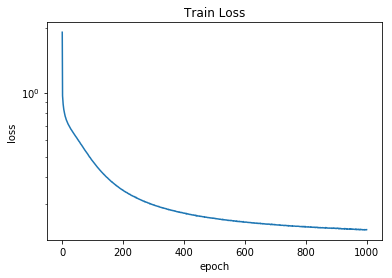

In [21]:
batch_size = 1024
path = './models/MovieLens_FM_{}k_aux'.format(k)
num_epoch = int(1e3)
lr = 1e-1
weight_decay = 1e-8
criterion = nn.MSELoss()

model = FM(p, k).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)

loss_array = []
min_loss = np.inf
for e in range(num_epoch):
    loss_array_tmp = []

    for X_train_batch, Y_train_batch in train_loader:

        out = model(X_train_batch.to(device))
        loss = criterion(out, Y_train_batch.to(device))
        loss_array_tmp.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 10.)
        optimizer.step()

    loss_array.append(np.mean(loss_array_tmp))
    if e % 10 == 0: 
        print('Epoch: {}, Loss: {:.4e}'.format(e, loss_array[-1]))

    ## update the minimum loss
    if min_loss > loss_array[-1]:
        patience = 0
        patience_scheduler = 0
        min_loss = loss_array[-1]
        torch.save(model.state_dict(), path)
    else:
        patience += 1

    ## early stop when patience become larger than 100
    if patience > 100:
        break

plt.plot(loss_array)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.title('Train Loss')
plt.show()

torch.cuda.empty_cache()

In [22]:
model = FM(p, k).to(device)
model.load_state_dict(torch.load(path, map_location = device))
model.eval()

loss_array_tmp = []
for X_train_batch, Y_train_batch in train_loader:

    out = model(X_train_batch.to(device))
    loss = criterion(out, Y_train_batch.to(device))
    loss_array_tmp.append(loss.item())

print('Train RMSE = {:.4f}'.format(np.sqrt(np.mean(loss_array_tmp))))

loss_array_tmp = []
for X_train_batch, Y_train_batch in test_loader:

    out = model(X_train_batch.to(device))
    loss = criterion(out, Y_train_batch.to(device))
    loss_array_tmp.append(loss.item())

print('Test RMSE = {:.4f}'.format(np.sqrt(np.mean(loss_array_tmp))))

Train RMSE = 0.4729
Test RMSE = 1.0530


In [31]:
model = FM(p, k).to(device)
model.load_state_dict(torch.load(path, map_location = device))
model.eval()

true_array = []
pred_array = []
for X_train_batch, Y_train_batch in train_loader:

    out = model(X_train_batch.to(device))
    pred_array.append(out.detach().cpu().numpy())
    true_array.append(Y_train_batch.detach().numpy())

true_array = np.concatenate(true_array)
pred_array = np.concatenate(pred_array)
pred_array = (np.floor(2*pred_array+0.5)/2).clip(0.5, 5.0)

print('Train Accuracy = {:.4f}'.format((true_array == pred_array).mean()))

true_array = []
pred_array = []
for X_train_batch, Y_train_batch in test_loader:

    out = model(X_train_batch.to(device))
    pred_array.append(out.detach().cpu().numpy())
    true_array.append(Y_train_batch.detach().numpy())

true_array = np.concatenate(true_array)
pred_array = np.concatenate(pred_array)
pred_array = (np.floor(2*pred_array+0.5)/2).clip(0.5, 5.0)

print('Test Accuracy = {:.4f}'.format((true_array == pred_array).mean()))

Train Accuracy = 0.5281
Test Accuracy = 0.2035


In [55]:
testdat = dat_ratings[dat_ratings['timestamp'] > dat_ratings['timestamp'].quantile(.8)].reset_index()
testdat['PredRating'] = pred_array
testdat = testdat.set_index(['index'])

In [56]:
testdat[testdat['userId'] == testdat['userId'].unique()[0]].sort_values(by=['PredRating'], ascending=False)

,userId,movieId,rating,timestamp,PredRating
index,,,,,
1521,15,60069,3.5,1510577951,5.0
1482,15,3499,4.0,1510572526,5.0
1530,15,72998,3.0,1510572052,5.0
1545,15,105504,4.0,1510572616,5.0
1475,15,2571,4.0,1510571744,5.0
1476,15,2762,3.0,1510571764,5.0
1477,15,2858,4.0,1510571751,5.0
1531,15,79132,3.5,1510571930,5.0
1479,15,2959,2.5,1510571747,5.0
